In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, show_comparison, centering_image, save_gif
from get_data.package import pickle_interpolation_data

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

### 150epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

### Load data

In [7]:
fixed_char_ids = torch.load(os.path.join(data_dir, 'fixed_char_ids.pkl'))
fixed_char_ids = fixed_char_ids.numpy()
fixed_char_ids

array([    8,   193,   876,  1189,  1992,  2499,  3059,  3519,  3544,
        3755,  4245,  5264,  5328,  5681,  6473,  6748,  7468,  7708,
        8617,  9399,  9416, 10129, 10840, 11032])

In [8]:
except_ = [1, 2, 3, 4, 22, 23, 24]
font_filter = [i for i in range(25)if i not in except_]
len(font_filter)

18

In [9]:
font_filter_plus = font_filter + [font_filter[0]]
font_filter_plus

[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 0]

In [10]:
data_provider = TrainDataProvider(data_dir, train_name="interpolation_data.obj", val=False)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 432 examples
train examples -> 432
total batches: 24


---

# font interpolation - one font to another
-  1, 2, 3, 4, 23, 24는 위 글씨가 모두 존재하는게 아니므로 제외, 18개 맞추기 위해서 22도 제외


- 이번에는 encorded source를 가져와서, 다른 encorded source와의 중간점을 거쳐서 옮겨가보는 실험


- 같은 글자가 필요


- `0` ~ `5` ~ `6` ~ `8` ~ `10` ~ `0` 으로의 interpolation 진행

### Interpolate할 폰트 순서

In [11]:
interpolated_font_ids = [(i, font_filter_plus[font_filter.index(i)+1]) for i in font_filter]
interpolated_font_ids

[(0, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 0)]

In [12]:
font_filter

[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### 각 font변환에 대해서 나눠서 저장
- character 8에 대해서 `0 -> 5`, `5 -> 6` , ... , `21 -> 0` 을 각각 저장할 directory 생성

### `grids` : Interpolating parameter

- grid별로 한 번씩 돌아가면서 결과를 저장해야 함

In [13]:
step = 10
grids = list(np.linspace(0.3, 0.7, step))
grids = [0., 0., 0.1, 0.2] + grids + [0.8, 0.9, 1., 1.]
len(grids)

18

In [14]:
def interpolation(data_provider, grids, fixed_char_ids, interpolated_font_ids, embeddings, \
                  En, De, batch_size, img_size=128, save_path=False, GPU=True):
    
    train_batch_iter = data_provider.get_train_iter(batch_size, with_charid=True)
    
    for grid_idx, grid in enumerate(grids):
        train_batch_iter = data_provider.get_train_iter(batch_size, with_charid=True)
        grid_results = {from_to: {charid: None for charid in fixed_char_ids} \
                        for from_to in interpolated_font_ids}

        # total_batch=24, 24번 도는 for문
        for i, batch in enumerate(train_batch_iter):

            # batch_size=18, batch에는 18개의 data 포함
            font_ids_from, char_ids, batch_images = batch
            font_filter = [i[0] for i in interpolated_font_ids]
            font_filter_plus = font_filter + [font_filter[0]]
            font_ids_to = [font_filter_plus[font_filter.index(i)+1] for i in font_ids_from]
            batch_images = batch_images.cuda()

            # 18개의 source/target_from/target_to images 추출
            # source는 같아서 from/to가 나뉘지 않는다
            real_sources = batch_images[:, 1, :, :].view([batch_size, 1, img_size, img_size])
            real_targets = batch_images[:, 0, :, :].view([batch_size, 1, img_size, img_size])

            # 18개의 encoded_source 생성
            # encoded_source, encode_layer는 interpolate할 필요 없다
            encoded_source, encode_layers = En(real_sources)

            # embedding interpolation 생성
            interpolated_embeddings = []
            embedding_dim = embeddings.shape[3]
            for from_, to_ in zip(font_ids_from, font_ids_to):
                interpolated_embeddings.append((embeddings[from_] * (1 - grid) + \
                                                embeddings[to_] * grid).cpu().numpy())
            interpolated_embeddings = torch.tensor(interpolated_embeddings).cuda()
            interpolated_embeddings = interpolated_embeddings.reshape(batch_size, embedding_dim, 1, 1)

            # generate fake image with embedded source
            interpolated_embedded = torch.cat((encoded_source, interpolated_embeddings), 1)
            fake_targets = De(interpolated_embedded, encode_layers)

            # grid_results에 결과 저장
            # [(0)real_S, (1)real_T, (2)fake_T]
            for fontid, charid, real_S, real_T, fake_T in zip(font_ids_from, char_ids, \
                                                              real_sources, real_targets, \
                                                              fake_targets):
                font_from = fontid
                font_to = font_filter_plus[font_filter.index(fontid)+1]
                from_to = (font_from, font_to)
                grid_results[from_to][charid] = [real_S, real_T, fake_T]

        if save_path:
            for from_to in grid_results.keys():
                image = [grid_results[from_to][charid][2].cpu().detach().numpy() for \
                         charid in fixed_char_ids]
                image = torch.tensor(np.array(image))

                # path
                font_from = str(from_to[0])
                font_to = str(from_to[1])
                grid_idx = str(grid_idx)
                if len(font_from) == 1:
                    font_from = '0' + font_from
                if len(font_to) == 1:
                    font_to = '0' + font_to
                if len(grid_idx) == 1:
                    grid_idx = '0' + grid_idx
                file_path = 'from_%s_to_%s_grid_%s.png' % (font_from, font_to, grid_idx)

                # save
                save_image(denorm_image(image.data), \
                           os.path.join(save_path, file_path), \
                           nrow=6, pad_value=255)
    
    return grid_results

In [16]:
save_path = './interpolation/images/'
grid_results = interpolation(data_provider, grids, fixed_char_ids, interpolated_font_ids, \
                             embeddings, En, De, batch_size=BATCH_SIZE, save_path=save_path, \
                             img_size=128, GPU=True)

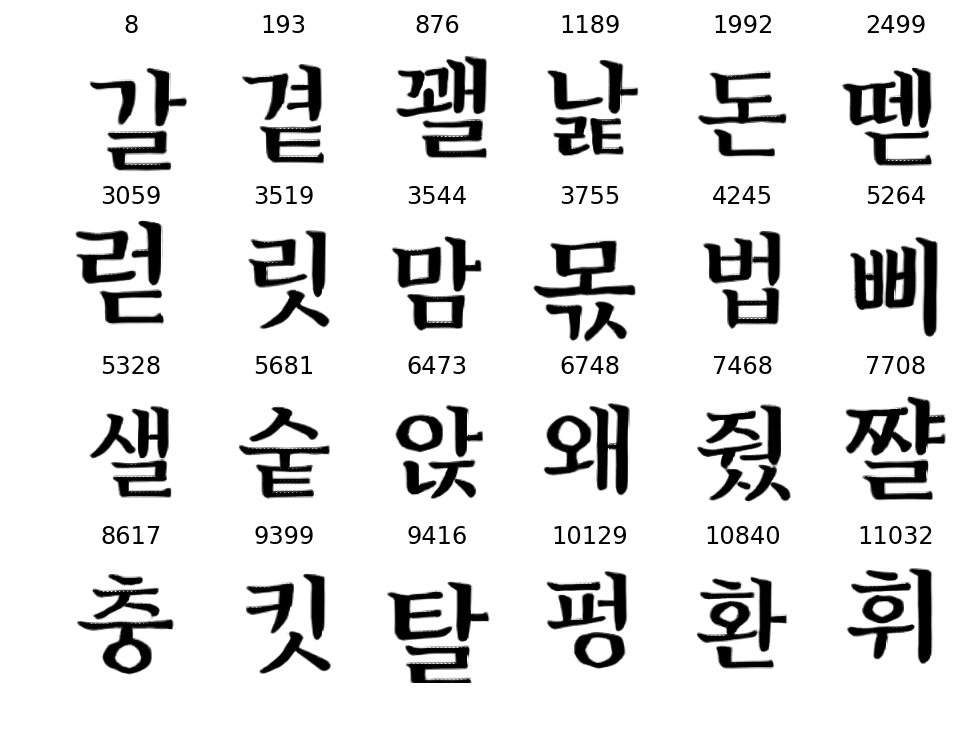

In [17]:
plt.figure(figsize=(8, 6))

for idx, charid in enumerate(fixed_char_ids):
    plt.subplot(4, 6, idx+1)
    plt.imshow(grid_results[(21, 0)][charid][2].cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.title(charid)
    plt.axis('off')
plt.show()